### Setup
1. Import modules
2. Explore datasets: feature data, training data
3. Data cleaning:
    1. Text cleaning
    2. Text normalization

In [2]:
import pandas as pd
import re

from text_utils import text_cleaner, text_merger
from image_utils import image_data_extractor, detect_bounding_box_parallel, crop_pad_and_resize_image_parallel, find_duplicates_parallel, create_duplicates_dataframe

X_test = pd.read_csv("X_test.csv", index_col=0)
X_train = pd.read_csv("X_train.csv", index_col=0)
y_train = pd.read_csv("y_train.csv", index_col=0)

# Create DataFrame for text content like 'designation' and 'decription'
df_text = pd.merge(X_train, y_train, left_index=True, right_index=True)

# Create DataFrame for images
#df_image = df_text.drop(columns=["designation", "description"])
#df_image.set_index(keys="productid", inplace=True)

#df_text.head()

,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,"PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en main<br> Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile<br> En bonus : Support inclu pour GamePad<br> <span class=""vga_style2""><b></b><br>",201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...,278535884,1077757786,2705


### Exploration of text data

Display basic **information** about the text data

In [89]:
print(df_text.info())

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB
None


**Question:** What is the size of the original dataset for training?

In [90]:
# Get size of DataFrame
cells = df_text.size

# Get shape of DataFrame in order to get number of rows (products) and columns (attributes)
df_text.shape

rows = df_text.shape[0]
cols = df_text.shape[1]

print(f'The original dataset contains a total of {cells:,} cells.', end='\n\n')
print(f'The data are distributed over {rows:,} products with {cols} attributes:')

# Get names of columns for better understanding of attributes
column_names = df_text.columns

for nr, cn in enumerate(column_names, start=1): # nr as in "number", cn as in "column name"
    print(f'\t{nr}. {cn}')

The original dataset contains a total of 424,580 cells.

The data are distributed over 84,916 products with 5 attributes:
	1. designation
	2. description
	3. productid
	4. imageid
	5. prdtypecode


**Question:** Are there any missing values (NaN)?

In [91]:
print('The original data set has missing descriptions:')

df_text.isna().any()

The original data set has missing descriptions:


designation    False
description     True
productid      False
imageid        False
prdtypecode    False
dtype: bool

**Question:** How many missing values are we looking at?

In [92]:
description_nan = df_text['description'].isna()
description_nan_amt = description_nan.sum()

print(f'The training data has {description_nan_amt:,} missing values in the column \'description\'.')

df_text.isna().sum()

The training data has 29,800 missing values in the column 'description'.


designation        0
description    29800
productid          0
imageid            0
prdtypecode        0
dtype: int64

### Duplicate values
Step 2 // Preprocessing: Duplicate items [[Issue #16]](https://github.com/PeterStieg/feb25_bds_classification-of-rakuten-e-commerce-products/issues/16)
- Amount of duplicate values per column (attribute)
- Most frequent product titles (designation)
- Most frequent product description

**Question:** Are there any duplicate values?

In [93]:
duplicate_values = {}

for cn in column_names:
   cn_duplicates = df_text[cn].duplicated().sum()
   
   if cn_duplicates:
      pct = cn_duplicates / rows
      print(f'The column \033[1m\'{cn}\'\033[0m has {cn_duplicates:,} duplicate values: {pct:.2%}')
      
      # Add data to dictionary for later comparison
      duplicate_values[cn] = [int(cn_duplicates), round(pct, 2)]

The column 'designation' has 2,651 duplicate values: 3.12%
The column 'description' has 37,409 duplicate values: 44.05%
The column 'prdtypecode' has 84,889 duplicate values: 99.97%


**Question:** What are the most common duplicate values for product titles (designation)?

In [94]:
designation_value_counts = df_text['designation'].value_counts().sort_values(ascending=False)
designation_value_counts_top5 = designation_value_counts.iloc[:5]
print(designation_value_counts_top5)

designation
5d Broderie Peintures Strass Diamant Bricolage Pasted Peinture Point De Croix       76
Simple Linen Creative Belle Oreiller Taie D'oreiller Taie D'oreiller Car Cover      28
Cotton Linen Place Décoratifs Pour La Maison Coussin Case Canapé Taille Coussin     25
Imprimer Taie Polyester Canapé Coussin Car Cover Home Decor                         22
Joyeuse Saint-Valentin Jetez Taie D'oreiller Sweet Love Coussin Carré Couverture    21
Name: count, dtype: int64


**Question:** What are the most common duplicate values for product descriptions?

In [95]:
description_value_counts = df_text['description'].value_counts().sort_values(ascending=False)
description_value_counts_top5 = description_value_counts.iloc[:5]
print(description_value_counts_top5)

description
<br>Attention !!! Ce produit est un import  si les informations 'langues' et 'sous-titres' n'apparaissent pas sur cette fiche produit c'est que l'éditeur ne nous les a pas fournies. Néanmoins dans la grande majorité de ces cas il n'existe ni langue ni sous titres en français sur ces imports.    252
Taille: En format A5 (144 cm x 21 cm) Caractéistique: -Excellente durabilité avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualitévous pouvez y érire facilement                                                                                      232
Taille: En format A5 (144 cm x 21 cm) Caracteristique: -Excellente durabilite avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualite:  ecrire facilement sur et assez epaisse.                                                                         189
Taille: En format A5 (144 cm x 21 cm) Caract?istique: -Excellente durabilit?avec couvert

**Question:** How many products with missing descriptions have duplicated designations?

In [96]:
# Get rows of DataFrame with missing descriptions
df_descr_nan = df_text[description_nan] # filter defined in 'Exploration of text data'

# Get number of rows with duplicate titles (designation)
missDescription_duplTitle_amt = df_descr_nan['designation'].duplicated().sum()

print(f'Only {missDescription_duplTitle_amt:,} products with a missing description have a duplicate title (designation).', end='\n\n')
print(f'Compared to a total of {description_nan_amt:,} products with a missing description, this is only {missDescription_duplTitle_amt / description_nan_amt:.2%} of the total.')

Only 120 products with a missing description have a duplicate title (designation).
Compared to a total of 29,800 products with a missing description, this is only 0.40% of the total.


**Question:** Does the number of duplicate titles and descriptions increase after **cleaning the string variables?**

**Proprecessing steps** with function *text_cleaner()* from text_utils.py, which
1. Removes:
    1. Leading and trailing spaces 
    2. HTML tags, e.g. \<br>, \<br />, \<b>

2. Replaces:
    1. HTML entities with their corresponding characters, e.g. &eacute; → è, &auml; → ä, &ntilde; → ñ 
    2. Control characters with empty strings, e.g. Ã, Â©, �
    3. Multiple spaces with a single space

In [ ]:
# Create new DataFrame with cleaned text columns

#df_text_clean = text_cleaner(df_text) # Duration 16apr2025: 5min 39s
#df_text_clean.to_csv('df_text_clean.csv', index=False)
#df_text_clean.head()

,designation,description,productid,imageid,prdtypecode,designation_cleaned,description_cleaned,designation_org_clean,designation_spaces,designation_upper,...,designation_encoding_issue,designation_control_chars,description_org_clean,description_spaces,description_upper,description_lower,description_html_tag,description_html_entity,description_encoding_issue,description_control_chars
0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,,True,False,False,...,False,False,True,False,False,False,False,False,False,False
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,,True,False,False,...,False,False,True,False,False,False,False,False,False,False
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,"PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en main<br> Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile<br> En bonus : Support inclu pour GamePad<br> <span class=""vga_style2""><b></b><br>",201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U. Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant. Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad Caractéristiques: Modèle: Speedlink PILOT STYLE Touch Pen Couleur: Bleu Ref. Fabricant: SL-3468-BE Compatibilité: GamePad Nintendo Wii U Forme particulièrement ergonomique excellente tenue en main Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile En bonus : Support inclu pour GamePad,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),,True,False,False,...,False,False,True,False,False,False,False,False,False,False
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...,278535884,1077757786,2705,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en être le vainqueur incontesté. Mais Sophie s'en mêle et chambarde tous ses plans...,True,False,False,...,False,False,False,False,False,False,False,True,False,False


**Questions:**
1. What do the cleaned strings look like?
2. How many characters did we save by cleaning strings?

In [ ]:
df_text_clean = pd.read_csv('df_text_clean.csv')
df_text_copy = df_text_clean.copy()

df_text_len = df_text_copy[["designation", "designation_cleaned", "designation_len", "designation_cleaned_len", "designation_saved_len", "description", "description_cleaned", "description_len", "description_cleaned_len", "description_saved_len"]]

designation_len = df_text_len['designation_len'].sum()
description_len = df_text_len['description_len'].sum()
designation_saved_len = df_text_len['designation_saved_len'].sum()

designation_cleaned_len = df_text_len['designation_cleaned_len'].sum()
description_cleaned_len = df_text_len['description_cleaned_len'].sum()
description_saved_len = df_text_len['description_saved_len'].sum()

pct_saved = (designation_saved_len + description_saved_len) / (designation_len + description_len) * 100

print(f"\033[1mDesignation\033[0m:")
print(f"\tTotal length of designation: {designation_len:,}")
print(f"\tTotal length of cleaned designation: {designation_cleaned_len:,}")
print(f"\tAmount of saved chars in designation: {designation_saved_len:,}", end="\n\n")

print(f"\033[1mDescription\033[0m:")
print(f"\tTotal length of description: {description_len:,}")
print(f"\tTotal length of cleaned description: {description_cleaned_len:,}")
print(f"\tAmount of saved chars in description: {description_saved_len:,}", end="\n\n")

print(f"\033[1mSummary\033[0m:")
print(f"\tTotal amount of saved chars: {designation_saved_len + description_saved_len:,} ({pct_saved:.2f}%)")

df_text_len_sorted = df_text_len.sort_values(by = "description_saved_len", ascending=False)

df_text_len_sorted.head()

**Comparison** of number of duplicates in the orig. and cleaned DataFrame

In [98]:
text_cols = ['designation_cleaned', 'description_cleaned']

for cn_clean in text_cols:
  cn_duplicates = df_text_clean[cn_clean].duplicated().sum()
  pct = cn_duplicates / rows

  # Get the previous value from the dictionary
  
  cn = re.sub('_cleaned', '', cn_clean)
  pct_incr = pct - duplicate_values[cn][1]

  print(f'The cleaned column \033[1m\'{cn_clean}\'\033[0m has...')
  print(f'\t{cn_duplicates:,} duplicates compared to {duplicate_values[cn][0]:,} (+{cn_duplicates - duplicate_values[cn][0]:,})')
  print(f'\tAn increase of {pct_incr:.2%} from {duplicate_values[cn][1]:.2%} to {pct:.2%}', end='\n\n')

The cleaned column 'designation_cleaned' has...
	2,657 duplicates compared to 2,651 (+6)
	An increase of 0.13% from 3.00% to 3.13%

The cleaned column 'description_cleaned' has...
	37,605 duplicates compared to 37,409 (+196)
	An increase of 0.28% from 44.00% to 44.28%



**Question:** Does the number of identical original string variables differ from cleaned string variables?

**Proprecessing steps** with function *text_merger()* from text_utils.py:
1. Compare original string variables and set flags
2. Compare cleaned string variables and set flags
3. Merge cleaned string variables – if applicable

In [99]:
#df_text_merge = text_merger(df_text_clean) # Duration 11apr2025: 23s

#df_text_merge.to_csv('df_text_merge.csv', index=False)
#df_text_merge.head()

,designation,description,productid,imageid,prdtypecode,designation_cleaned,description_cleaned,designation_org_clean,designation_spaces,designation_upper,...,description_lower,description_html_tag,description_html_entity,description_encoding_issue,description_control_chars,designation_empty,description_empty,identical_original,identical_cleaned,text_merged
0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,,True,False,False,...,False,False,False,False,False,False,False,False,False,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design //
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,,True,False,False,...,False,False,False,False,False,False,False,False,False,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans. //
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,"PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en main<br> Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile<br> En bonus : Support inclu pour GamePad<br> <span class=""vga_style2""><b></b><br>",201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U. Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant. Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad Caractéristiques: Modèle: Speedlink PILOT STYLE Touch Pen Couleur: Bleu Ref. Fabricant: SL-3468-BE Compatibilité: GamePad Nintendo Wii U Forme particulièrement ergonomique excellente tenue en main Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile En bonus : Support inclu pour GamePad,True,False,False,...,False,True,False,False,False,False,False,False,False,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style // PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U. Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant. Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad Caractéristiques: Modèle: Speedlink PILOT STYLE Touch Pen Couleur: Bleu Ref. Fabricant: SL-3468-BE Compatibilité: GamePad Nintendo Wii U Forme particulièrement ergonomique excellente tenue en main Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile En bonus : Support inclu pour GamePad
3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,45704

## Exploration of image data

## Preprocessing // Load DataFrame with image data
`Note:` The repository contains an updated and preprocessed version of df_image.csv

In [100]:
df_image = pd.read_csv("df_image.csv", index_col="productid")

#df_image.head()

,productid,imageid,error
0,3804725264,1263597046,File not found
1,436067568,1008141237,File not found
2,201115110,938777978,File not found
3,50418756,457047496,File not found
4,278535884,1077757786,File not found


**Preprocessing // Images**

`NOTE:` Running the following cell to extract data from all image files and save it to df_image.csv is **only necessary after** an update of the module image_utils.py. Otherwise you can proceed with the import in the next code cell of you interest

In [ ]:
#df_image = image_data_extractor(df_image)         # Command takes a while to run: ~ 1 hour
#df_image.to_csv('df_image.csv', index=False)
#df_image.head()

**Import image data**
1. File information, e.g.
    1. productid
    2. imageid
2. Size information
    1. width, height, ...
    2. aspect_ratio
3. EXIF and meta data
    1. meta_jfif, ... meta_progressive, ...
    2. mean_r, mean_g, mean_b, mean_brightness, ... 

In [101]:
df_image = pd.read_csv('df_image.csv')
df_image.head()

,productid,imageid,error
0,3804725264,1263597046,File not found
1,436067568,1008141237,File not found
2,201115110,938777978,File not found
3,50418756,457047496,File not found
4,278535884,1077757786,File not found


**Question:** How many aspect ratios are in the DataFrame?

**Answer:** All product images have an aspect ratio of 1:1 with a resolution of 500 × 500 px

Relates to [Issue #45 Step 2 // Preprocessing: Image Processing](https://github.com/PeterStieg/feb25_bds_classification-of-rakuten-e-commerce-products/issues/45)


In [ ]:
"""
df_img_pt = pd.pivot_table(df_image[['aspect_ratio', 'width', 'height']],
                           index='aspect_ratio',
                           aggfunc={'aspect_ratio': 'count', 'height': 'mean', 'width': 'mean'})

pt_img_ar = pt_img_ar.rename(columns={'aspect_ratio': 'count'})

df_img_pt"
"""

SyntaxError: EOF while scanning triple-quoted string literal (3273490954.py, line 8)

## Preprocessing // Images: Crop and resize to target size

Relates to Issue [Issue #63 Step 2 // Preprocessing: Crop and resize image](https://github.com/PeterStieg/feb25_bds_classification-of-rakuten-e-commerce-products/issues/63)
1. Crop and resize images contained in a DataFrame according to bounding box dimensions
2. Add columns 'downscaled', 'upscaled' and 'exclude' to DataFrame df_image(.csv)

In [ ]:
df_image = pd.read_csv("df_image.csv", index_col="productid")
df_image = crop_pad_and_resize_image_parallel(df_image) # Duration 22apr2025: 6min 34s
#df_image.to_csv("df_image.csv")
#df_image.head()

## Preprocessing // Images: Find duplicates with perceptual hashing

Relates to Issue [Issue #67 Step 2 // Preprocessing: Find duplicates with perceptual hashing](https://github.com/PeterStieg/feb25_bds_classification-of-rakuten-e-commerce-products/issues/67)
1. Compute perceptual hash
2. Add columns 'phash' to DataFrame df_image(.csv)

In [ ]:
#df_image = pd.read_csv("df_image.csv", index_col="productid")
#df_image = hash_parallel(df_image) # Duration 22apr2025: 5min 14s
#df_image.to_csv("df_image.csv")
#df_image.head()

In [ ]:
#df_image = pd.read_csv("df_image.csv", index_col="productid")

#df_image, unique_duplicates = find_duplicates_parallel(df_image, threshold=0) # Duration 23apr2025: 42min
#df_image.to_csv(f"df_image.csv")

# Create a DataFrame from the duplicate pairs
#df_image_duplicates = create_duplicates_dataframe(unique_duplicates)
#df_image_duplicates.to_csv(f"df_image_duplicates.csv", index=False)
#df_image_duplicates.head()


Processing 84,916 images in 141 chunks using 14 workers


Finding duplicate hashes: 100%|██████████| 141/141 [42:25<00:00, 18.06s/it]  


Found 29538 unique duplicate pairs with threshold 0
Marked 11517 images as duplicates in the DataFrame


## Exploration of target data (product type code)

**Question:** What does the target data look like?

In [103]:
y_train.head()

,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


Display basic **information** about the target data

In [ ]:
print(y_train.info())

**Question:** Are there any missing values (NaN)?

In [104]:
print("The attribute \033[1m'product type code'\033[0m has no missing data:")

y_train.isna().any()

The attribute 'product type code' has no missing data:


prdtypecode    False
dtype: bool

**Question:** How many different product type codes are there?

In [105]:
prdtypecode_list = sorted(set(y_train['prdtypecode']))
prdtypecode_len = len(prdtypecode_list)

print(f"List containing all \033[1m{prdtypecode_len} product type codes\033[0m:")
print(prdtypecode_list, end='\n\n')

**Assigning Product Type Codes to Categories**

In [106]:
# Define a dictionary for French category names:
# Product type code -> Product Category, French
prdtypecode_dict_FR = {   
    10: 'Livres > ??More than 1 Sub-Category??',
    2280: 'Livres > Revue',
    2705: 'Livres > eBooks',
    2522: 'Livres > Fournitures Papeterie',
    2403: 'Livres > Lots de Livres et de Revues',

    50: 'Jeux vidéo & Consoles > Accessoires Jeux Vidéo',
    1140: 'Jeux vidéo & Consoles > Figurines',
    1180: 'Jeux vidéo & Consoles > Jeux de rôle et jeux de figurines',
    2462: 'Jeux vidéo & Consoles > Lots de consoles et jeux vidéo',
    1160: 'Jeux vidéo & Consoles Cartes de jeux',
    40: 'Jeux vidéo & Consoles > Jeux Vidéo',
    60: 'Jeux vidéo & Consoles > Consoles',
    2905: 'Jeux vidéo & Consoles > Jeux Vidéo > Jeux vidéo PC', #3. Ebene! Unterkategorie von 60
    
    1280: 'Jouets > Enfant Jouets',
    1300: 'Jouets & Enfant > Modélisme',
    1320: 'Jouets & Enfant > Puériculture',
    1302: 'Jouets & Enfant Jeux de plein air',
    1301: 'Jouets & Enfant > Jeux de café',
    1281: 'Jouets & Enfant > Jeux de société ',
    
    2582: 'Jardin & Piscine > Mobilier de jardin',
    2583: 'Jardin & Piscine > Entretien piscine & spa',
    2585: 'Jardin & Piscine > Outillage de jardin',

    1560: 'Maison > Mobilier ',
    1920: '??Maison > 1640 Linge de Maison ??',#nochmal checken
    2060: '??Maison > decoration??', #nochmal checken

    1940: 'Vins et Gastronomie > Petit déjeuner',

    2220: 'Animalerie > Accessoires et nourriture pour chien'
    }

                          
# Map the French dictionary to prdtypecode column
df_text['prod_cat_fr'] = df_text['prdtypecode'].map(prdtypecode_dict_FR)                          
                                            

# Define a dictionary for English category names:
# Product type code -> Product Category, English
# Peter 31mar2025: We could simplify the code by using a single dictionary for both French and English categories.
prdtypecode_dict_EN = {
    10: 'Books > ??More than 1 Sub-Category??',
    2280: 'Books > Magazine',
    2705: 'Books > eBooks',
    2522: 'Books > Stationery Supplies',
    2403: 'Books > Batches of Books and Magazines',

    50: 'Video Games & Consoles > Video Game Accessories',
    1140: 'Video Games & Consoles > Figures',
    1180: 'Video Games & Consoles > Role-playing games and miniature games',
    2462: 'Video Games & Consoles > Batches of consoles and video games',
    1160: 'Video Games & Consoles Game cards',
    40: 'Video Games & Consoles > Video Games',
    60: 'Video Games & Consoles > Consoles',
    2905: 'Video Games & Consoles > Video Games > PC video games', #3. Ebene! Unterkategorie von 60
    
    1280: 'Toys & Children > Toys',
    1300: 'Toys & Children > Model making',
    1320: 'Toys & Children > Childcare',
    1302: 'Toys & Children > Outdoor games',
    1301: 'Toys & Children > Cafe games',
    1281: 'Toys & Children > Board games',
    
    2582: 'Garden & Pool > Garden furniture',
    2583: 'Garden & Pool > Pool & spa maintenance',
    2585: 'Garden & Pool > Garden tools',

    1560: 'Home > Furniture',
    1920: '??Home > 1640 Household Linens??',#nochmal checken
    2060: '??Home > decoration??', #nochmal checken

    1940: 'Wines and Gastronomy > Breakfast',

    2220: 'Pet Store > Dog Accessories and Food'
    }

# Map the English dictionary to prdtypecode column
df_text['prod_cat_en'] = df_text['prdtypecode'].map(prdtypecode_dict_EN)                          


"""
Category / Subcategory?
Issues:

1. Category 10 seems to belong to more than one subcategory of books, yet it is not the parent category of the other subcategories. (100)
2. Category 60 seems to be the parent category of 2905.
3. I can not confirm Categories 1920 & 2060. I could not find them in the html/css code of the website.

Suggestions:
1. ?
2. Change Category 2950 to 60 for consistency. Check for duplicates in category 60.
3. ?

"""

# Display DataFrame 'df_text' to verify
display(df_text.head())

,designation,description,productid,imageid,prdtypecode,prod_cat_fr,prod_cat_en
0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10,Livres > ??More than 1 Sub-Category??,Books > ??More than 1 Sub-Category??
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,436067568,1008141237,2280,Livres > Revue,Books > Magazine
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,"PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en main<br> Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile<br> En bonus : Support inclu pour GamePad<br> <span class=""vga_style2""><b></b><br>",201115110,938777978,50,Jeux vidéo & Consoles > Accessoires Jeux Vidéo,Video Games & Consoles > Video Game Accessories
3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280,Jouets > Enfant Jouets,Toys & Children > Toys
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...,278535884,1077757786,2705,Livres > eBooks,Books > eBooks


**Assigning Parent Categories**

In [107]:
# Define a dictionary for parent categories in French
parent_category_dict_fr = {
    10: 'Livres',
    2280: 'Livres',
    2705: 'Livres',
    2522: 'Livres',
    2403: 'Livres',
    50: 'Jeux vidéo et consoles',
    1140: 'Jeux vidéo et consoles',
    1180: 'Jeux vidéo et consoles',
    2462: 'Jeux vidéo et consoles',
    1160: 'Jeux vidéo et consoles',
    40: 'Jeux vidéo et consoles',
    60: 'Jeux vidéo et consoles',
    2905: 'Jeux vidéo et consoles',  # Parent category of 2905 is 60
    1280: 'Jouets et enfants',
    1300: 'Jouets et enfants',
    1320: 'Jouets et enfants',
    1302: 'Jouets et enfants',
    1301: 'Jouets et enfants',
    1281: 'Jouets et enfants',
    2582: 'Jardin et piscine',
    2583: 'Jardin et piscine',
    2585: 'Jardin et piscine',
    1560: 'Maison',
    1920: 'Maison',
    2060: 'Maison',
    1940: 'Vins et gastronomie',
    2220: 'Animalerie'
    }

# Map the parent category to a new column using the French dictionary
df_text['parent_category_fr'] = df_text['prdtypecode'].map(parent_category_dict_fr)


# Define a dictionary for English parent categories
# Peter 31mar2025: We could simplify the code by using a single dictionary for both French and English categories.
parent_category_dict_en = {
    10: 'Books',
    2280: 'Books',
    2705: 'Books',
    2522: 'Books',
    2403: 'Books',
    50: 'Video Games & Consoles',
    1140: 'Video Games & Consoles',
    1180: 'Video Games & Consoles',
    2462: 'Video Games & Consoles',
    1160: 'Video Games & Consoles',
    40: 'Video Games & Consoles',
    60: 'Video Games & Consoles',
    2905: 'Video Games & Consoles',  # Parent category of 2905 is 60
    1280: 'Toys & Children',
    1300: 'Toys & Children',
    1320: 'Toys & Children',
    1302: 'Toys & Children',
    1301: 'Toys & Children',
    1281: 'Toys & Children',
    2582: 'Garden & Pool',
    2583: 'Garden & Pool',
    2585: 'Garden & Pool',
    1560: 'Home',
    1920: 'Home',
    2060: 'Home',
    1940: 'Wines and Gastronomy',
    2220: 'Pet Store'
    }


# Map the parent category to a new column using the English dictionary
df_text['parent_category_en'] = df_text['prdtypecode'].map(parent_category_dict_en)


# Display DataFrame 'df_text' to verify
display(df_text.head())

,designation,description,productid,imageid,prdtypecode,prod_cat_fr,prod_cat_en,parent_category_fr,parent_category_en
0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10,Livres > ??More than 1 Sub-Category??,Books > ??More than 1 Sub-Category??,Livres,Books
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,436067568,1008141237,2280,Livres > Revue,Books > Magazine,Livres,Books
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,"PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en main<br> Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile<br> En bonus : Support inclu pour GamePad<br> <span class=""vga_style2""><b></b><br>",201115110,938777978,50,Jeux vidéo & Consoles > Accessoires Jeux Vidéo,Video Games & Consoles > Video Game Accessories,Jeux vidéo et consoles,Video Games & Consoles
3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280,Jouets > Enfant Jouets,Toys & Children > Toys,Jouets et enfants,Toys & Children
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...,278535884,1077757786,2705,Livres > eBooks,Books > eBooks,Livres,Books


## Text Normalization

In [ ]:
"""
IMPORTANT NOTES:

Text normalization has been put into backlog of our project. Since I have already started working on this process, I did not want to loose progress. 
All the following steps are just a first sketch of the process.


- In the described process: Stemming or lemmatization is not included because contextual embeddings (CamemBERT) already handle word variations and synonyms effectively.
- synonym mapping, regular expressions, and tokenization are largely redundant when using contextual embeddings like CamemBERT.
- Stopword removal is optional when using contextual embeddings like CamemBERT, as they can handle common words effectively.


If we want to apply the following we must save it for the test data, 
to be processed in the same way as the training data. Can this be handled in the pipeline?
"""

#ALL CODE IN TRIPPLE QUOTES TO NOT EXECUTE IT

"""
# 1. Lowercasing and Remove Accents
#Normalize the text by lowercasing and removing accents. This step ensures consistency.

import unicodedata 
# Peter 31mar2025: I could/would use this module in the function text_cleaner() during text cleaning

def normalize_text(text):
    # Lowercase
    text = text.lower()
    # Remove accents
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    return text

# Apply normalization to both columns
df_text['designation'] = df_text['designation'].apply(normalize_text)
df_text['description'] = df_text['description'].apply(normalize_text)

# 2. Generating Contextual Embeddings
#Using CamemBERT to generate embeddings for each row in the title and description columns. 
#This step captures the semantic meaning of the text.

from transformers import CamembertTokenizer, CamembertModel 
# Peter 31mar2025: I would move all imports to the setup section of the notebook

# Load the tokenizer and model
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertModel.from_pretrained("camembert-base")

import torch

def get_embedding(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Pass the input through the model
    outputs = model(**inputs)
    # Extract the embeddings (mean of the last hidden state)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Generate embeddings for titles and descriptions
df_text['designation_embedding'] = df_text['designation'].apply(get_embedding)
df_text['description_embedding'] = df_text['description'].apply(get_embedding)

# 3. Automatically Cluster Similar Rows
#Instead of manually defining synonyms or rules, using unsupervised clustering to group similar rows based on their embeddings.
import numpy as np

# Combining title and description embeddings
# Combining the designation_embedding and description_embedding into a single vector for each row.
df_text['combined_embedding'] = df_text.apply(
    lambda row: np.mean([row['designation_embedding'], row['description_embedding']], axis=0),
    axis=1
)
# Cluster Rows
#Using K-Means clustering to group similar rows based on their combined embeddings.

from sklearn.cluster import KMeans

# Stack all embeddings into a matrix
embedding_matrix = np.vstack(df_text['combined_embedding'])

# Cluster embeddings into groups
num_clusters = 5  # Adjust based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_text['cluster'] = kmeans.fit_predict(embedding_matrix)

# 4. Replace Text with Cluster Representatives
# Automatically replace the text in each cluster with a representative phrase 
# (e.g., the most frequent phrase in the cluster).

# Find Cluster Representatives
# Find the most common title or description in each cluster.

# Find the representative title for each cluster
cluster_representatives = df_text.groupby('cluster')['designation'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# Replace titles and descriptions with their cluster representative
df_text['normalized_designation'] = df_text['cluster'].map(cluster_representatives)
df_text['normalized_description'] = df_text['cluster'].map(cluster_representatives)

# 5. Save the Normalized Data
# Save the normalized DataFrame for further use.


df_text.to_csv("normalized_products.csv", index=False)"
"""

In [108]:
long_titles = df_text[df_text['designation'].str.len()>=240]
print(long_titles['designation'])

## Data visualization

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

**1. Distribution of Product Type Codes**

In [110]:
# Get value counts and sort them
sorted_value_counts = df_text['prod_cat_en'].value_counts().sort_values(ascending=False)
category_order = sorted_value_counts.index.tolist()


# Abbreviate category names
abbreviated_labels = [label[:15] + '...' if len(label) > 10 else label for label in category_order]

plt.figure(figsize=(12, 6))
sns.countplot(x='prod_cat_en', data=df_text, order=category_order)

plt.xticks(ticks=range(len(category_order)), labels=abbreviated_labels, rotation=90)
plt.title('Number of Items per Category')
plt.xlabel('Product Categories')
plt.ylabel('Count')
plt.show()

Here we have two different versions of the same plot. I find the matplotlib one visually more pleasing plus it is sorted, which makes it easier to interpret.

In [ ]:
product_type_counts = y_train['prdtypecode'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
product_type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Product Type Codes', fontsize=16)
plt.xlabel('Product Type Code', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

As we can see the product type codes are not equally distibuted. The code 2583 is by far the most represented code with >10k counts. Approximately a third of the rest of the codes have around 4-5k counts, followed by another third with around 3k counts, and the last third with around 1k count each.

The exact percentages of each codes value count is displayed in the following pie chart.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    product_type_counts,
    autopct='%1.1f%%',  # Display percentages
    startangle=90,
    colors=plt.cm.tab20.colors,  # Use colormap
    textprops={'fontsize': 10},  # Adjust font size for better readability
    pctdistance=1.1  # Move percentages outside the pie
)

# Add a legend outside the pie chart
ax.legend(
    wedges,
    product_type_counts.index,  # Labels for the legend
    title="Product Type Codes",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),  # Position legend outside the chart
    fontsize=10
)
plt.show()

Here we have the distribution on parent category level:

In [ ]:
# Get the distribution of English parent categories
category_distribution = df_text['parent_category_en'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of English Parent Categories', fontsize=16)
plt.xlabel('Parent Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

**2. Distributions of items without descriptions**

Maybe we can also sort this, and use the same style graph as above for unified look.

In [ ]:
# Calculate counts for the filtered DataFrame and sort them in descending order
sorted_value_counts = df_text[df_text.isnull().any(axis=1)]['prod_cat_en'].value_counts().sort_values(ascending=False)
category_order = sorted_value_counts.index.tolist()

# Abbreviate category names
abbreviated_labels = [label[:15] + '...' if len(label) > 15 else label for label in category_order]

# Create the countplot
plt.figure(figsize=(12, 6))
sns.countplot(x='prod_cat_en', data=df_text[df_text.isnull().any(axis=1)], order=category_order)

# Apply abbreviated labels and rotate them
plt.xticks(ticks=range(len(category_order)), labels=abbreviated_labels, rotation=90)
plt.title('Countplot of items without descriptions')
plt.xlabel('Product Categories')
plt.ylabel('Count')
plt.show()

Interpretation?/Observations?

The same graph but on parent category level:

In [ ]:
# Filter the DataFrame for rows with missing descriptions
missing_description_df = df_text[df_text.isnull().any(axis=1)]

# Plot the count of English parent categories with missing descriptions
plt.figure(figsize=(12, 6))
sns.countplot(x='parent_category_en', data=missing_description_df, palette='viridis')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Countplot of Items Without Descriptions by Parent Category', fontsize=16)
plt.xlabel('English Parent Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

**3. Distribution of items with description**

Maybe use one style and order descending?

In [ ]:
# Calculate counts for the filtered DataFrame (rows with descriptions) and sort them in descending order
sorted_value_counts_with_desc = df_text[df_text.notnull().all(axis=1)]['prod_cat_en'].value_counts().sort_values(ascending=False)
category_order_with_desc = sorted_value_counts_with_desc.index.tolist()

# Abbreviate category names
abbreviated_labels_with_desc = [label[:15] + '...' if len(label) > 15 else label for label in category_order_with_desc]

# Create the countplot
plt.figure(figsize=(12, 6))
sns.countplot(x='prod_cat_en', data=df_text[df_text.notnull().all(axis=1)], order=category_order_with_desc)

# Apply abbreviated labels and rotate them
plt.xticks(ticks=range(len(category_order_with_desc)), labels=abbreviated_labels_with_desc, rotation=90)
plt.title('Countplot of items with descriptions')
plt.xlabel('Product Categories')
plt.ylabel('Count')
plt.show()

Interpretation?/Observations?

The same on parent category level:

In [ ]:
# Filter the DataFrame for rows with descriptions (no missing values)
with_description_df = df_text[df_text.notnull().all(axis=1)]

# Plot the count of English parent categories with descriptions
plt.figure(figsize=(12, 6))
sns.countplot(x='parent_category_en', data=with_description_df, palette='viridis')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Countplot of Items With Descriptions by Parent Category', fontsize=16)
plt.xlabel('English Parent Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

**4. Relative distribution of product descriptions**

In [ ]:
# Calculate total counts and counts with descriptions for each parent category
total_counts = df_text['parent_category_en'].value_counts()
with_description_counts = df_text[df_text.notnull().all(axis=1)]['parent_category_en'].value_counts()

# Calculate the percentage of items with descriptions
description_percentage = (with_description_counts / total_counts) * 100

# Plot the percentage of items with descriptions
plt.figure(figsize=(12, 6))
description_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Items With Descriptions by Parent Category', fontsize=16)
plt.xlabel('English Parent Categories', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

**4. Distribution of Title Lengths**

In [ ]:
# Calculate the length of each product title
df_text['title_length'] = df_text['designation'].str.len()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_text,
    x='title_length',
    bins=25,  # Number of bins for the histogram
    kde=True,  # Add a kernel density estimate (smooth curve)
    color='skyblue'
)

# Add labels and title
plt.title('Distribution of Product Title Lengths', fontsize=16)
plt.xlabel('Title Length (Number of Characters)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

The title lengths follow a somewhat normal and bimodal distributed, but there is a heavy scew to the left, with a bit of a tail to right, getting very thin above 150 characters. Interestingly there is a small spike at around 250 characters. This peak might be due to a maximum allowed length, which also explains why there are no extreme outliers. The rest of the data is distributed around the largest peak in the 40 - 50 character range, and another smaller peak at 80 - 90 characters.

**5. Distribution of description length**

5.1 Histogram of Product Description Lengths

In [ ]:
# Calculate the length of each product title
df_text['description_length'] = df_text['description'].str.len()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_text,
    x='description_length',
    bins=25,  # Number of bins for the histogram
    kde=True,  # Add a kernel density estimate (smooth curve)
    color='skyblue'
)

# Add labels and title

We see that there is a very long tail with extremely long descriptions.

5.2 Boxplot of Product Description lenghts

In [ ]:
# Calculate the length of each product title (if not already done)
df_text['description_length'] = df_text['description'].str.len()

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_text,
    x='description_length',
    color='skyblue'
)

# Add labels and title
plt.title('Boxplot of Product Description Lengths', fontsize=16)
plt.xlabel('Description Length (Number of Characters)', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

There are a lot of outliers with extremely long descriptions. Let's take a closer look at the outliers:

In [ ]:
# Calculate the IQR (Interquartile Range)
Q1 = df_text['description_length'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df_text['description_length'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Calculate the upper whisker threshold
upper_whisker = Q3 + 1.5 * IQR

# Count the number of outliers above the upper whisker
outliers_above = df_text[df_text['description_length'] > upper_whisker]
outlier_count = len(outliers_above)

print(f"The threshold for outliers is {upper_whisker} words in the description.")
print(f"Number of outliers above the upper whisker: {outlier_count}")
print(f"Percentage of outliers: {outlier_count / len(df_text) * 100:.2f}%")

Samples of Outliers:

In [ ]:
# Filter outliers above the upper whisker
outliers_above = df_text[df_text['description_length'] > upper_whisker]

# Display the descriptions of 5 outliers
print(outliers_above['description'].head(5))

Some of the descriptions feature a lot of blank spaces. The first description has 160 before the text. Some, but not all outliers seem to have html code in them.

Sample of normal length descriptions:

In [ ]:
# Calculate the IQR (Interquartile Range)
Q1 = df_text['description_length'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df_text['description_length'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Calculate the lower and upper whisker thresholds
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Filter descriptions within the normal range (inside the box of the boxplot)
normal_range = df_text[(df_text['description_length'] >= lower_whisker) & (df_text['description_length'] <= upper_whisker)]

# Display 5 descriptions from the normal range
print(normal_range['description'].sample(5))

The normal lenth code also has a very few html snippets, but much less than the long texts.

5.3 Distribution of descriptions without outliers

In [ ]:
# Calculate the length of each product title
df_text['description_length'] = df_text['description'].str.len()

# Filter the DataFrame for description lengths shorter than 2196.5
filtered_df = df_text[df_text['description_length'] < 2196.5]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=filtered_df,
    x='description_length',
    bins=25,  # Number of bins for the histogram
    kde=True,  # Add a kernel density estimate (smooth curve)
    color='skyblue'
)

# Add labels and title
plt.title('Distribution of Product Description Lengths (< 2196.5)', fontsize=16)
plt.xlabel('Title Length (Number of Characters)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()


Let's zoom in on the very short descriptions:

In [ ]:
# Calculate the length of each product title
df_text['description_length'] = df_text['description'].str.len()

# Filter the DataFrame for description lengths shorter than 2196.5
filtered_df = df_text[df_text['description_length'] < 100]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=filtered_df,
    x='description_length',
    bins=25,  # Number of bins for the histogram
    kde=True,  # Add a kernel density estimate (smooth curve)
    color='skyblue'
)

# Add labels and title
plt.title('Distribution of Product Description Lengths (< 2196.5)', fontsize=16)
plt.xlabel('Title Length (Number of Characters)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

Let us take a look at very short descriptions, though they are not technically outliers.

In [ ]:
# Filter outliers above the upper whisker
outliers_above = df_text[df_text['description_length'] < 30]

# Display the descriptions of 5 outliers
print(outliers_above['description'].head(5))

Some descriptions are essentially NaNs (e.g.) "<br / >", others seem to only add little information to the title ("designation"). More clear after cleaning and merger of title and description.

**6. Word Clouds of descriptions**

In [ ]:
from data_viz import word_cloud
word_cloud(df_text, 'prdtypecode', 'description')

**5. Word Clouds of designation**


In [ ]:
word_cloud(df_text, 'prdtypecode', 'designation')

How much text did we save by cleaning?

In [114]:
# Calculate the total number of characters in df['description'] and df['designation']
total_description_chars = df['description'].str.len().sum()
total_designation_chars = df['designation'].str.len().sum()

# Calculate the total number of characters in df_merge['text_merged']
total_text_merged_chars = df_merge['text_merged'].str.len().sum()

# Print the results
print(f"Total characters in df['description']: {total_description_chars:,}")
print(f"Total characters in df['designation']: {total_designation_chars:,}")
print(f"Total characters in df_merge['text_merged']: {total_text_merged_chars:,}")

# Compare the totals
print("\nComparison:")
print(f"Sum of df['description'] and df['designation']: {total_description_chars + total_designation_chars:,}")
print(f"Total characters in df_merge['text_merged']: {total_text_merged_chars:,}")
print(f"relative difference: {abs(total_description_chars + total_designation_chars - total_text_merged_chars) / (total_description_chars + total_designation_chars) * 100:.2f}%")

Total characters in df['description']: 44,543,188.0
Total characters in df['designation']: 5,957,987
Total characters in df_merge['text_merged']: 47,752,286

Comparison:
Sum of df['description'] and df['designation']: 50,501,175.0
Total characters in df_merge['text_merged']: 47,752,286
relative difference: 5.44%


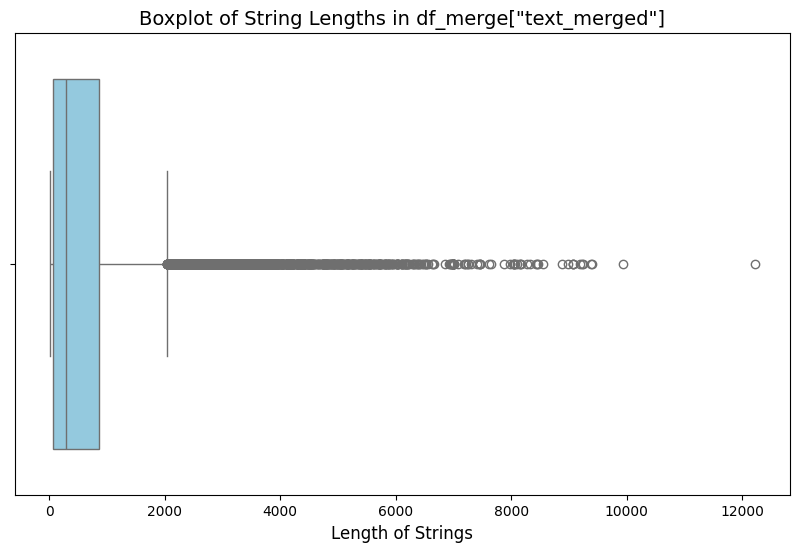

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of strings in df_merge['text_merged']
text_lengths = df_merge['text_merged'].str.len()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths, color='skyblue')

# Add labels and title
plt.title('Boxplot of String Lengths in df_merge["text_merged"]', fontsize=14)
plt.xlabel('Length of Strings', fontsize=12)

# Show the plot
plt.show()

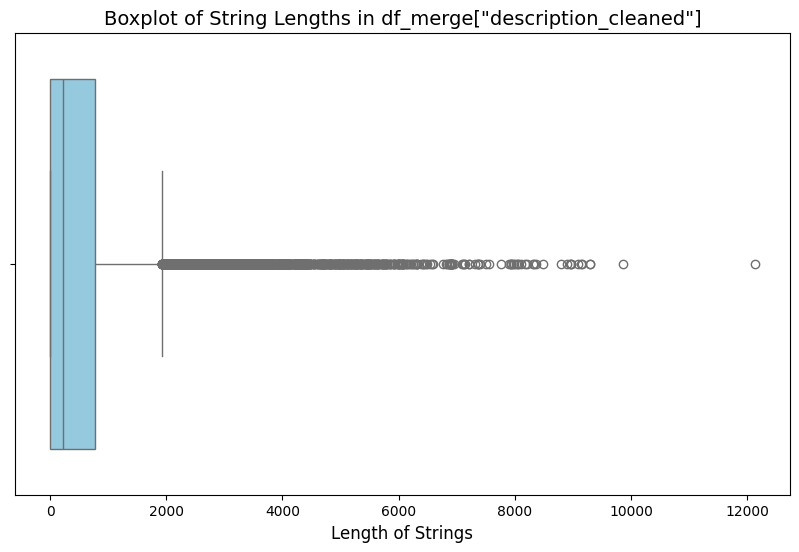

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of strings in df_merge['text_merged']
text_lengths = df_merge['description_cleaned'].str.len()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths, color='skyblue')

# Add labels and title
plt.title('Boxplot of String Lengths in df_merge["description_cleaned"]', fontsize=14)
plt.xlabel('Length of Strings', fontsize=12)

# Show the plot
plt.show()

In [113]:
# Calculate the IQR (Interquartile Range)
Q1 = text_lengths.quantile(0.25)  # First quartile (25th percentile)
Q3 = text_lengths.quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Calculate the upper whisker threshold
upper_whisker = Q3 + 1.5 * IQR

# Count the number of outliers above the upper whisker
outliers_above = df[text_lengths > upper_whisker]
outlier_count = len(outliers_above)

print(f"The threshold for outliers is {upper_whisker} words in the description.")
print(f"Number of outliers above the upper whisker: {outlier_count}")
print(f"Percentage of outliers: {outlier_count / len(df) * 100:.2f}%")

The threshold for outliers is 2045.5 words in the description.
Number of outliers above the upper whisker: 3167
Percentage of outliers: 3.73%


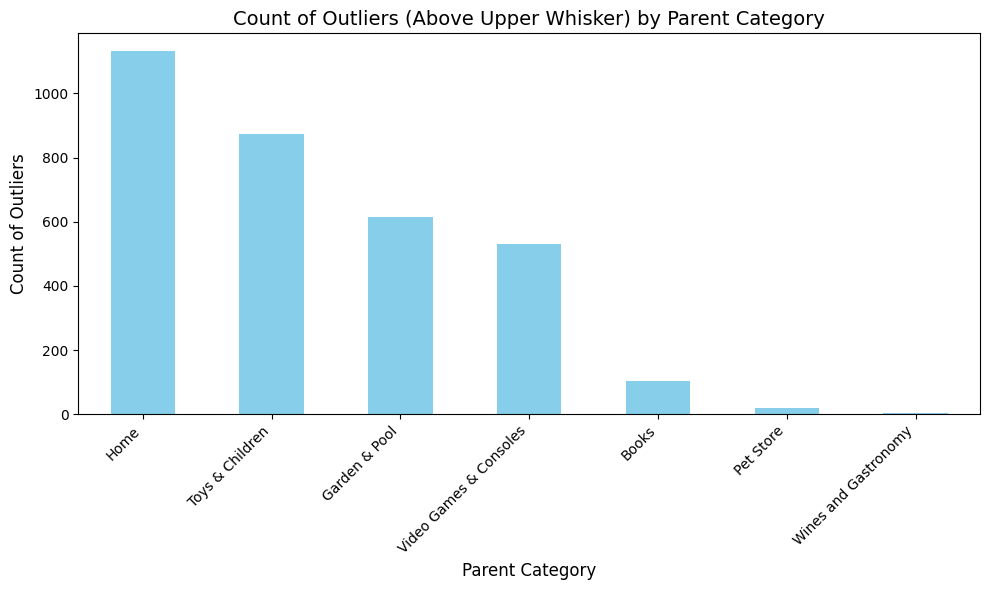

The threshold for outliers is 1930.0 characters in the description.
Number of outliers above the upper whisker: 3275
Percentage of outliers: 3.86%


In [ ]:
# Group by 'parent_category_en' and count the number of outliers
outliers_by_category = outliers_above.groupby('parent_category_en').size()

# Plot the results as a bar plot
plt.figure(figsize=(10, 6))
outliers_by_category.sort_values(ascending=False).plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Count of Outliers (Above Upper Whisker) by Parent Category', fontsize=14)
plt.xlabel('Parent Category', fontsize=12)
plt.ylabel('Count of Outliers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Print additional information
print(f"The threshold for outliers is {upper_whisker} characters in the description.")
print(f"Number of outliers above the upper whisker: {len(outliers_above)}")
print(f"Percentage of outliers: {len(outliers_above) / len(df) * 100:.2f}%")

In [ ]:
long_titles = df[df['designation'].str.len()>=240]
pd.set_option('display.max_colwidth', None) 
# Peter 31mar2025: I would set this option in the setup section of the notebook after all imports
print(long_titles['designation'])

169      Action Francaise (L') N° 287 Du 15/10/1923 - L'agonie De L'evolutionnisme Par Leon Daudet - Explosion D'un Fort A Varsovie - 150 Morts - 2.500 Blesses - La Politique - I - La Lumiere Des Morts - Ii - Deux Points Noirs - Iii - Le Rebut Du Monde - I...
499      Moniteur Universel (Le) N° 56 Du 25/02/1853 - Partie Officielle - Presentation Des Lettres Qui Confirment M Le Ministre Extraordinaire Du Bresil En Cette Qualite Aupres De Sa Majeste - Partie Non Officielle - Lettre De M Powles A Lord Mount-Edgeum...
517      T7j Yannick Noah 3p/ Star Wars 1p/ Jean Pierre Michael Ris 1p/ Ophelie Winter 4p/ Dominic Monaghan Evangeline Lilly 1p/ Severine Ferrer 1p/ Nicolas Cage 1.5p/ Albert Monaco 2p/ Julie Gayet 2p/ Robbie Williams 1.5p/ Coluche 2p/Romain Sardou 1/2p/ 2373
518      Daily Mail N° 19307 Du 19/05/1958 - France At A Glance  -   De Gaulle Chooses Today  -   Cabinet Order More Safety Measures Reluctant Revolt British Warships Stand By For Lebanon Rescue A Sting From The Drones T

In [ ]:
# Count the number of duplicate entries in df_merge['text_merged']
num_duplicates = df_merge['text_merged'].duplicated().sum()

# Print the result
print(f"Number of duplicate entries in df_merge['text_merged']: {num_duplicates}")

In [ ]:
# Drop duplicates based on 'designation_cleaned' and 'description_cleaned', keeping only the first occurrence
unique_df = df_merge.drop_duplicates(subset=['designation_cleaned', 'description_cleaned'])

# Calculate the total number of characters for the unique entries
total_designation_cleaned_chars = unique_df['designation_cleaned'].str.len().sum()
total_description_cleaned_chars = unique_df['description_cleaned'].str.len().sum()

# Print the results
print(f"Total characters in unique df_merge['designation_cleaned'] + df_merge['description_cleaned']: {total_designation_cleaned_chars + total_description_cleaned_chars:,}")
print(f"relative difference of clean and unique entries to original text length: {abs(total_description_chars + total_designation_chars - (total_designation_cleaned_chars + total_description_cleaned_chars)) / (total_description_chars + total_designation_chars) * 100:.2f}%")

If we can only translate the unique entries of the cleaned descriptions and titles ('designation'), before they are merged, we can save around 9% of characters maximum.


In [ ]:
long_descriptions = df_merge[df_merge['description_cleaned'].str.len()>=2200]
pd.set_option('display.max_colwidth', None) 
# Peter 31mar2025: I would set this option in the setup section of the notebook after all imports
display(long_descriptions['description_cleaned'])

I think to clean the description also did not work


In [ ]:
df_11 = df_merge.iloc[[11]][['designation', 'description','designation_cleaned', 'description_cleaned', 'text_merged']]

for index, row in df_11.iterrows():
    print(f"Row:\n\t{index}")
    print(f"Designation:\n\t'{row['designation']}'")
    print(f"Description:\n\t'{row['description']}'")
    print(f"Cleaned Designation:\n\t'{row['designation_cleaned']}'")
    print(f"Cleaned Description:\n\t'{row['description_cleaned']}'")
    print(f"Merged Text:\n\t'{row['text_merged']}'")

How much text did we save by cleaning?

In [ ]:
# Calculate the total number of characters in df_text['description'] and df_text['designation']
total_description_chars = df_text['description'].str.len().sum()
total_designation_chars = df_text['designation'].str.len().sum()

# Calculate the total number of characters in df_merge['text_merged']
total_text_merged_chars = df_merge['text_merged'].str.len().sum()

# Print the results
print(f"Total characters in df_text['description']: {total_description_chars:,}")
print(f"Total characters in df_text['designation']: {total_designation_chars:,}")
print(f"Total characters in df_merge['text_merged']: {total_text_merged_chars:,}")

# Compare the totals
print("\nComparison:")
print(f"Sum of df_text['description'] and df_text['designation']: {total_description_chars + total_designation_chars:,}")
print(f"Total characters in df_merge['text_merged']: {total_text_merged_chars:,}")
print(f"relative difference: {abs(total_description_chars + total_designation_chars - total_text_merged_chars) / (total_description_chars + total_designation_chars) * 100:.2f}%")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of strings in df_merge['text_merged']
text_lengths = df_merge['text_merged'].str.len()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths, color='skyblue')

# Add labels and title
plt.title('Boxplot of String Lengths in df_merge["text_merged"]', fontsize=14)
plt.xlabel('Length of Strings', fontsize=12)

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of strings in df_merge['text_merged']
text_lengths = df_merge['description_cleaned'].str.len()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths, color='skyblue')

# Add labels and title
plt.title('Boxplot of String Lengths in df_merge["description_cleaned"]', fontsize=14)
plt.xlabel('Length of Strings', fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Calculate the IQR (Interquartile Range)
Q1 = text_lengths.quantile(0.25)  # First quartile (25th percentile)
Q3 = text_lengths.quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Calculate the upper whisker threshold
upper_whisker = Q3 + 1.5 * IQR

# Count the number of outliers above the upper whisker
outliers_above = df_text[text_lengths > upper_whisker]
outlier_count = len(outliers_above)

print(f"The threshold for outliers is {upper_whisker} words in the description.")
print(f"Number of outliers above the upper whisker: {outlier_count}")
print(f"Percentage of outliers: {outlier_count / len(df_text) * 100:.2f}%")

In [ ]:
# Group by 'parent_category_en' and count the number of outliers
outliers_by_category = outliers_above.groupby('parent_category_en').size()

# Plot the results as a bar plot
plt.figure(figsize=(10, 6))
outliers_by_category.sort_values(ascending=False).plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Count of Outliers (Above Upper Whisker) by Parent Category', fontsize=14)
plt.xlabel('Parent Category', fontsize=12)
plt.ylabel('Count of Outliers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Print additional information
print(f"The threshold for outliers is {upper_whisker} characters in the description.")
print(f"Number of outliers above the upper whisker: {len(outliers_above)}")
print(f"Percentage of outliers: {len(outliers_above) / len(df_text) * 100:.2f}%")

In [ ]:
long_titles = df_text[df_text['designation'].str.len()>=240]
pd.set_option('display.max_colwidth', None) 
# Peter 31mar2025: I would set this option in the setup section of the notebook after all imports
print(long_titles['designation'])

In [ ]:
# Count the number of duplicate entries in df_merge['text_merged']
num_duplicates = df_merge['text_merged'].duplicated().sum()

# Print the result
print(f"Number of duplicate entries in df_merge['text_merged']: {num_duplicates}")

In [ ]:
# Drop duplicates based on 'designation_cleaned' and 'description_cleaned', keeping only the first occurrence
unique_df = df_merge.drop_duplicates(subset=['designation_cleaned', 'description_cleaned'])

# Calculate the total number of characters for the unique entries
total_designation_cleaned_chars = unique_df['designation_cleaned'].str.len().sum()
total_description_cleaned_chars = unique_df['description_cleaned'].str.len().sum()

# Print the results
print(f"Total characters in unique df_merge['designation_cleaned'] + df_merge['description_cleaned']: {total_designation_cleaned_chars + total_description_cleaned_chars:,}")
print(f"relative difference of clean and unique entries to original text length: {abs(total_description_chars + total_designation_chars - (total_designation_cleaned_chars + total_description_cleaned_chars)) / (total_description_chars + total_designation_chars) * 100:.2f}%")

If we can only translate the unique entries of the cleaned descriptions and titles ('designation'), before they are merged, we can save around 9% of characters maximum.


In [ ]:
long_descriptions = df_merge[df_merge['description_cleaned'].str.len()>=2200]
pd.set_option('display.max_colwidth', None) 
# Peter 31mar2025: I would set this option in the setup section of the notebook after all imports
display(long_descriptions['description_cleaned'])

I think to clean the description also did not work


In [ ]:
df_11 = df_merge.iloc[[11]][['designation', 'description','designation_cleaned', 'description_cleaned', 'text_merged']]

for index, row in df_11.iterrows():
    print(f"Row:\n\t{index}")
    print(f"Designation:\n\t'{row['designation']}'")
    print(f"Description:\n\t'{row['description']}'")
    print(f"Cleaned Designation:\n\t'{row['designation_cleaned']}'")
    print(f"Cleaned Description:\n\t'{row['description_cleaned']}'")
    print(f"Merged Text:\n\t'{row['text_merged']}'")

How much text did we save by cleaning?

In [ ]:
# Calculate the total number of characters in df_text['description'] and df_text['designation']
total_description_chars = df_text['description'].str.len().sum()
total_designation_chars = df_text['designation'].str.len().sum()

# Calculate the total number of characters in df_merge['text_merged']
total_text_merged_chars = df_merge['text_merged'].str.len().sum()

# Print the results
print(f"Total characters in df_text['description']: {total_description_chars:,}")
print(f"Total characters in df_text['designation']: {total_designation_chars:,}")
print(f"Total characters in df_merge['text_merged']: {total_text_merged_chars:,}")

# Compare the totals
print("\nComparison:")
print(f"Sum of df_text['description'] and df_text['designation']: {total_description_chars + total_designation_chars:,}")
print(f"Total characters in df_merge['text_merged']: {total_text_merged_chars:,}")
print(f"relative difference: {abs(total_description_chars + total_designation_chars - total_text_merged_chars) / (total_description_chars + total_designation_chars) * 100:.2f}%")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of strings in df_merge['text_merged']
text_lengths = df_merge['text_merged'].str.len()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths, color='skyblue')

# Add labels and title
plt.title('Boxplot of String Lengths in df_merge["text_merged"]', fontsize=14)
plt.xlabel('Length of Strings', fontsize=12)

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of strings in df_merge['text_merged']
text_lengths = df_merge['description_cleaned'].str.len()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths, color='skyblue')

# Add labels and title
plt.title('Boxplot of String Lengths in df_merge["description_cleaned"]', fontsize=14)
plt.xlabel('Length of Strings', fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Calculate the IQR (Interquartile Range)
Q1 = text_lengths.quantile(0.25)  # First quartile (25th percentile)
Q3 = text_lengths.quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Calculate the upper whisker threshold
upper_whisker = Q3 + 1.5 * IQR

# Count the number of outliers above the upper whisker
outliers_above = df_text[text_lengths > upper_whisker]
outlier_count = len(outliers_above)

print(f"The threshold for outliers is {upper_whisker} words in the description.")
print(f"Number of outliers above the upper whisker: {outlier_count}")
print(f"Percentage of outliers: {outlier_count / len(df_text) * 100:.2f}%")

In [ ]:
# Group by 'parent_category_en' and count the number of outliers
outliers_by_category = outliers_above.groupby('parent_category_en').size()

# Plot the results as a bar plot
plt.figure(figsize=(10, 6))
outliers_by_category.sort_values(ascending=False).plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Count of Outliers (Above Upper Whisker) by Parent Category', fontsize=14)
plt.xlabel('Parent Category', fontsize=12)
plt.ylabel('Count of Outliers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Print additional information
print(f"The threshold for outliers is {upper_whisker} characters in the description.")
print(f"Number of outliers above the upper whisker: {len(outliers_above)}")
print(f"Percentage of outliers: {len(outliers_above) / len(df_text) * 100:.2f}%")

In [ ]:
long_titles = df_text[df_text['designation'].str.len()>=240]
pd.set_option('display.max_colwidth', None) 
# Peter 31mar2025: I would set this option in the setup section of the notebook after all imports
print(long_titles['designation'])

In [ ]:
# Count the number of duplicate entries in df_merge['text_merged']
num_duplicates = df_merge['text_merged'].duplicated().sum()

# Print the result
print(f"Number of duplicate entries in df_merge['text_merged']: {num_duplicates}")

In [ ]:
# Drop duplicates based on 'designation_cleaned' and 'description_cleaned', keeping only the first occurrence
unique_df = df_merge.drop_duplicates(subset=['designation_cleaned', 'description_cleaned'])

# Calculate the total number of characters for the unique entries
total_designation_cleaned_chars = unique_df['designation_cleaned'].str.len().sum()
total_description_cleaned_chars = unique_df['description_cleaned'].str.len().sum()

# Print the results
print(f"Total characters in unique df_merge['designation_cleaned'] + df_merge['description_cleaned']: {total_designation_cleaned_chars + total_description_cleaned_chars:,}")
print(f"relative difference of clean and unique entries to original text length: {abs(total_description_chars + total_designation_chars - (total_designation_cleaned_chars + total_description_cleaned_chars)) / (total_description_chars + total_designation_chars) * 100:.2f}%")

If we can only translate the unique entries of the cleaned descriptions and titles ('designation'), before they are merged, we can save around 9% of characters maximum.


In [ ]:
long_descriptions = df_merge[df_merge['description_cleaned'].str.len()>=2200]
pd.set_option('display.max_colwidth', None) 
# Peter 31mar2025: I would set this option in the setup section of the notebook after all imports
display(long_descriptions['description_cleaned'])

I think to clean the description also did not work


In [ ]:
df_11 = df_merge.iloc[[11]][['designation', 'description','designation_cleaned', 'description_cleaned', 'text_merged']]

for index, row in df_11.iterrows():
    print(f"Row:\n\t{index}")
    print(f"Designation:\n\t'{row['designation']}'")
    print(f"Description:\n\t'{row['description']}'")
    print(f"Cleaned Designation:\n\t'{row['designation_cleaned']}'")
    print(f"Cleaned Description:\n\t'{row['description_cleaned']}'")
    print(f"Merged Text:\n\t'{row['text_merged']}'")

How much text did we save by cleaning?

In [ ]:
# Calculate the total number of characters in df_text['description'] and df_text['designation']
total_description_chars = df_text['description'].str.len().sum()
total_designation_chars = df_text['designation'].str.len().sum()

# Calculate the total number of characters in df_merge['text_merged']
total_text_merged_chars = df_merge['text_merged'].str.len().sum()

# Print the results
print(f"Total characters in df_text['description']: {total_description_chars:,}")
print(f"Total characters in df_text['designation']: {total_designation_chars:,}")
print(f"Total characters in df_merge['text_merged']: {total_text_merged_chars:,}")

# Compare the totals
print("\nComparison:")
print(f"Sum of df_text['description'] and df_text['designation']: {total_description_chars + total_designation_chars:,}")
print(f"Total characters in df_merge['text_merged']: {total_text_merged_chars:,}")
print(f"relative difference: {abs(total_description_chars + total_designation_chars - total_text_merged_chars) / (total_description_chars + total_designation_chars) * 100:.2f}%")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of strings in df_merge['text_merged']
text_lengths = df_merge['text_merged'].str.len()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths, color='skyblue')

# Add labels and title
plt.title('Boxplot of String Lengths in df_merge["text_merged"]', fontsize=14)
plt.xlabel('Length of Strings', fontsize=12)

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of strings in df_merge['text_merged']
text_lengths = df_merge['description_cleaned'].str.len()

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths, color='skyblue')

# Add labels and title
plt.title('Boxplot of String Lengths in df_merge["description_cleaned"]', fontsize=14)
plt.xlabel('Length of Strings', fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Calculate the IQR (Interquartile Range)
Q1 = text_lengths.quantile(0.25)  # First quartile (25th percentile)
Q3 = text_lengths.quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Calculate the upper whisker threshold
upper_whisker = Q3 + 1.5 * IQR

# Count the number of outliers above the upper whisker
outliers_above = df_text[text_lengths > upper_whisker]
outlier_count = len(outliers_above)

print(f"The threshold for outliers is {upper_whisker} words in the description.")
print(f"Number of outliers above the upper whisker: {outlier_count}")
print(f"Percentage of outliers: {outlier_count / len(df_text) * 100:.2f}%")

In [ ]:
# Group by 'parent_category_en' and count the number of outliers
outliers_by_category = outliers_above.groupby('parent_category_en').size()

# Plot the results as a bar plot
plt.figure(figsize=(10, 6))
outliers_by_category.sort_values(ascending=False).plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Count of Outliers (Above Upper Whisker) by Parent Category', fontsize=14)
plt.xlabel('Parent Category', fontsize=12)
plt.ylabel('Count of Outliers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Print additional information
print(f"The threshold for outliers is {upper_whisker} characters in the description.")
print(f"Number of outliers above the upper whisker: {len(outliers_above)}")
print(f"Percentage of outliers: {len(outliers_above) / len(df_text) * 100:.2f}%")

In [ ]:
long_titles = df_text[df_text['designation'].str.len()>=240]
pd.set_option('display.max_colwidth', None) 
# Peter 31mar2025: I would set this option in the setup section of the notebook after all imports
print(long_titles['designation'])

In [ ]:
# Count the number of duplicate entries in df_merge['text_merged']
num_duplicates = df_merge['text_merged'].duplicated().sum()

# Print the result
print(f"Number of duplicate entries in df_merge['text_merged']: {num_duplicates}")

In [ ]:
# Drop duplicates based on 'designation_cleaned' and 'description_cleaned', keeping only the first occurrence
unique_df = df_merge.drop_duplicates(subset=['designation_cleaned', 'description_cleaned'])

# Calculate the total number of characters for the unique entries
total_designation_cleaned_chars = unique_df['designation_cleaned'].str.len().sum()
total_description_cleaned_chars = unique_df['description_cleaned'].str.len().sum()

# Print the results
print(f"Total characters in unique df_merge['designation_cleaned'] + df_merge['description_cleaned']: {total_designation_cleaned_chars + total_description_cleaned_chars:,}")
print(f"relative difference of clean and unique entries to original text length: {abs(total_description_chars + total_designation_chars - (total_designation_cleaned_chars + total_description_cleaned_chars)) / (total_description_chars + total_designation_chars) * 100:.2f}%")

If we can only translate the unique entries of the cleaned descriptions and titles ('designation'), before they are merged, we can save around 9% of characters maximum.


In [ ]:
long_descriptions = df_merge[df_merge['description_cleaned'].str.len()>=2200]
pd.set_option('display.max_colwidth', None) 
# Peter 31mar2025: I would set this option in the setup section of the notebook after all imports
display(long_descriptions['description_cleaned'])

I think to clean the description also did not work


In [ ]:
df_11 = df_merge.iloc[[11]][['designation', 'description','designation_cleaned', 'description_cleaned', 'text_merged']]

for index, row in df_11.iterrows():
    print(f"Row:\n\t{index}")
    print(f"Designation:\n\t'{row['designation']}'")
    print(f"Description:\n\t'{row['description']}'")
    print(f"Cleaned Designation:\n\t'{row['designation_cleaned']}'")
    print(f"Cleaned Description:\n\t'{row['description_cleaned']}'")
    print(f"Merged Text:\n\t'{row['text_merged']}'")